In [ ]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.mem import *
from fastai.callbacks import *
from torchvision.models import *    # import *=all the models from torchvision  

path = Path('data/zgt-1'); path.ls()


[PosixPath('data/zgt-1/resnet152_bs:24.csv'),
 PosixPath('data/zgt-1/valid'),
 PosixPath('data/zgt-1/resnet50_bs:32.csv'),
 PosixPath('data/zgt-1/train'),
 PosixPath('data/zgt-1/densenet169_bs:32.csv'),
 PosixPath('data/zgt-1/densenet169_new.csv'),
 PosixPath('data/zgt-1/cleaned.csv'),
 PosixPath('data/zgt-1/resnet50_acc:91.csv'),
 PosixPath('data/zgt-1/models'),
 PosixPath('data/zgt-1/valid.zip'),
 PosixPath('data/zgt-1/alexnet.csv'),
 PosixPath('data/zgt-1/.~lock.alexnet.csv#'),
 PosixPath('data/zgt-1/resnet152_bs:32.csv'),
 PosixPath('data/zgt-1/squeezenet1_1_bs:32.csv')]

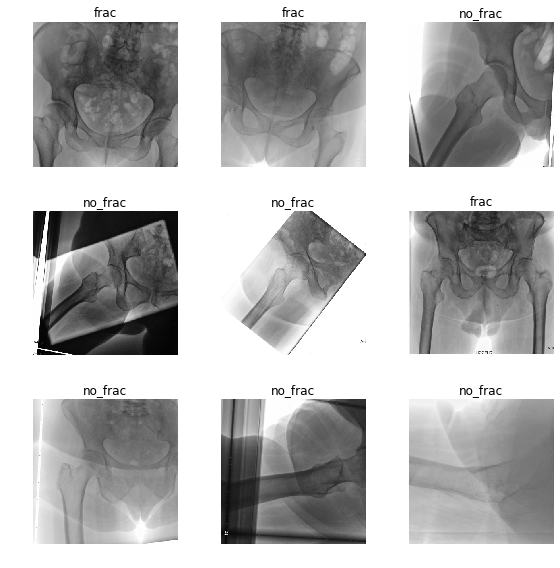

In [ ]:
bs = 32
# This is what we want to flip and move around; we want to do just basic stuff at first
no_tfms = get_transforms(do_flip=False)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)
data = ImageDataBunch.from_folder(path, ds_tfms=no_tfms, size=360, bs=bs).normalize(imagenet_stats)
# lists out the classes
data.classes
data.show_batch(rows=3, figsize=(8,8))



In [ ]:
learner = cnn_learner(data, models.densenet169,  metrics=[accuracy, error_rate, Recall()],
                   callback_fns=[ShowGraph, partial(CSVLogger, append=True, filename ='densenet169_new'),
              partial(ReduceLROnPlateauCallback,factor=0.01,min_delta=0.01, patience=3)])
learner.load('densenet169_new')

Learner(data=ImageDataBunch;

Train: LabelList (6952 items)
x: ImageList
Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360)
y: CategoryList
no_frac,no_frac,no_frac,no_frac,no_frac
Path: data/zgt-1;

Valid: LabelList (1676 items)
x: ImageList
Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360),Image (3, 360, 360)
y: CategoryList
no_frac,no_frac,no_frac,no_frac,no_frac
Path: data/zgt-1;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

## Define model architecture

In [ ]:
import pandas as pd 
  
# initialize list of lists 
data_ = [['Densenet121', 92.6], ['Densenet169', 96.5], ['Resnet50', 95.12]
       , ['Alexnet', 88.0], ['VGG_19', 92.8], ['Squuezenet', 88.12], ['Resnet152', 90]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data_, columns = ['Model', 'Accuracy']) 
  
# print dataframe. 
df.sort_values(by='Accuracy', ascending=False)


Model  Accuracy
1  Densenet169     96.50
2     Resnet50     95.12
4       VGG_19     92.80
0  Densenet121     92.60
6    Resnet152     90.00
5   Squuezenet     88.12
3      Alexnet     88.00

## Plot data augmentation

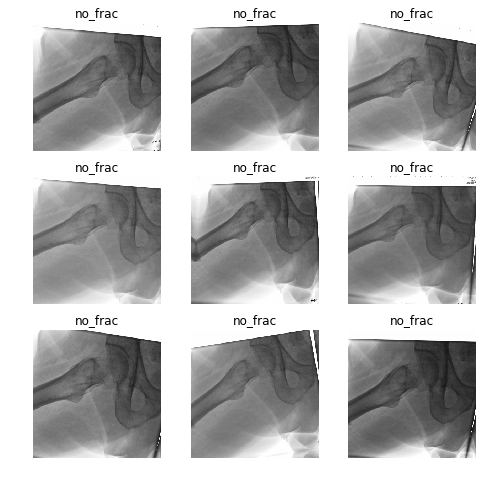

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

## Find optimal learning rate and weight decay values

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


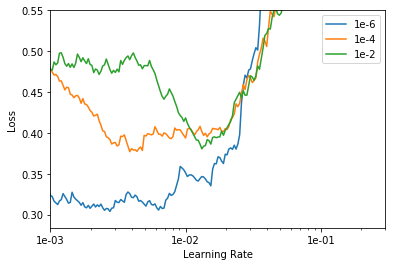

In [ ]:
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

## Train last layers of the model

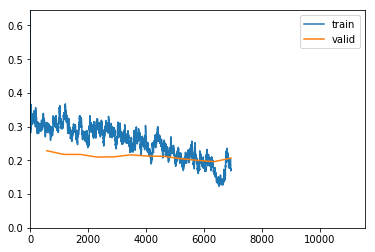

Epoch 5: reducing lr to 9.999999999999999e-06


Traceback (most recent call last):
  File "/home/mlemsalu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/mlemsalu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mlemsalu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/mlemsalu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/mlemsalu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/mlemsalu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mlemsalu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_by

KeyboardInterrupt: 

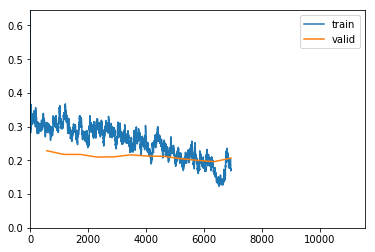

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(cyc_len=20, max_lr=slice(1e-6,1e-4), wd=1e-6)

## Unfreeze all layers and find the optimal learning late

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


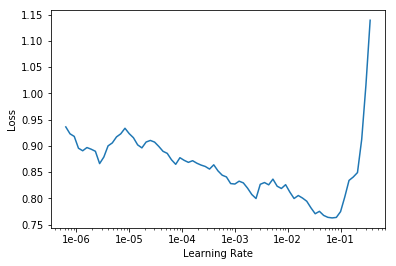

In [ ]:
learner.lr_find()
learner.recorder.plot()


In [ ]:
learn.fit_one_cycle(20, max_lr=slice(1e-05,1e-03))

KeyboardInterrupt: 

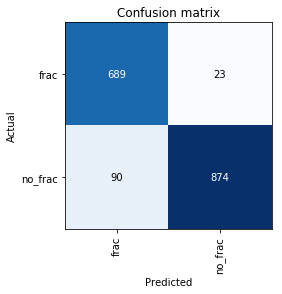

In [ ]:
#learner.recorder.plot_lr(show_moms=True)
#learner.recorder.plot_losses()
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

1586 misclassified samples over 1676 samples in the validation set.


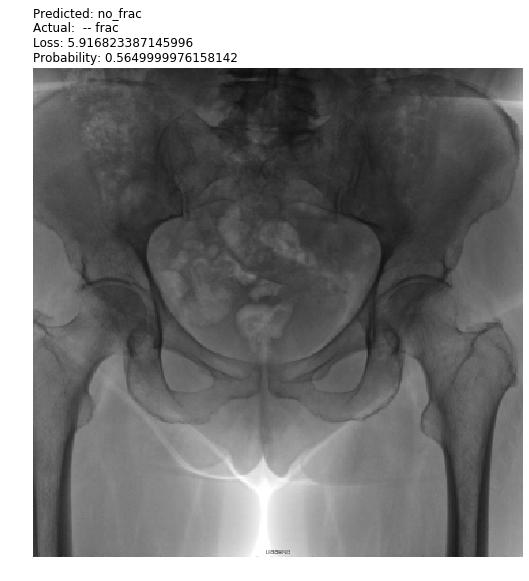

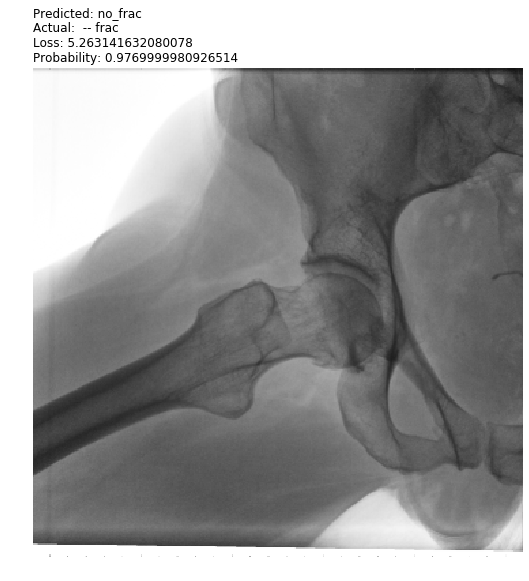

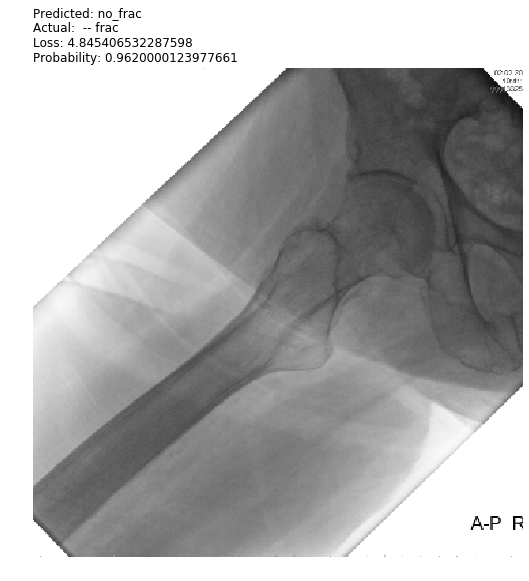

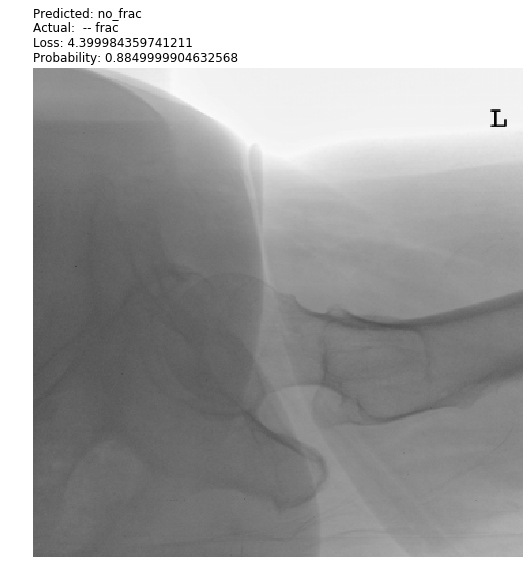

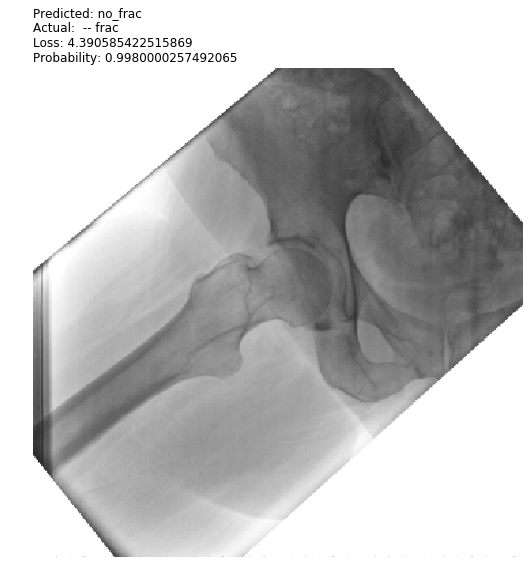

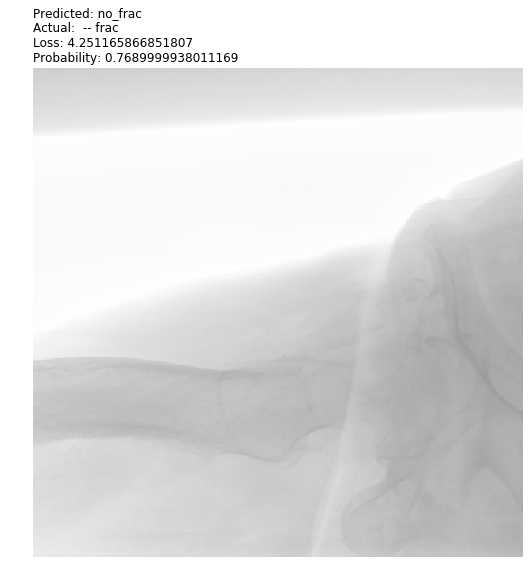

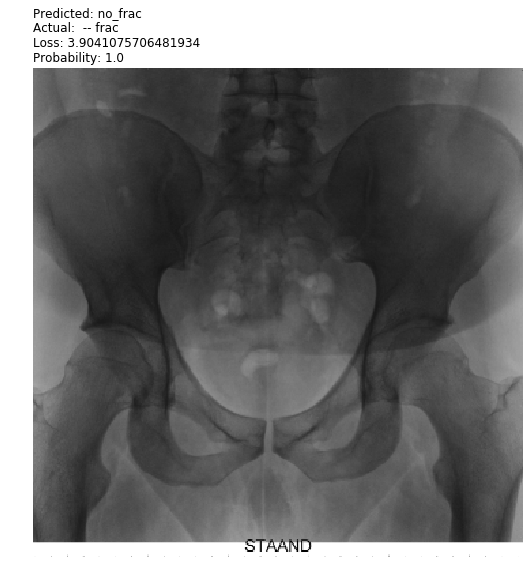

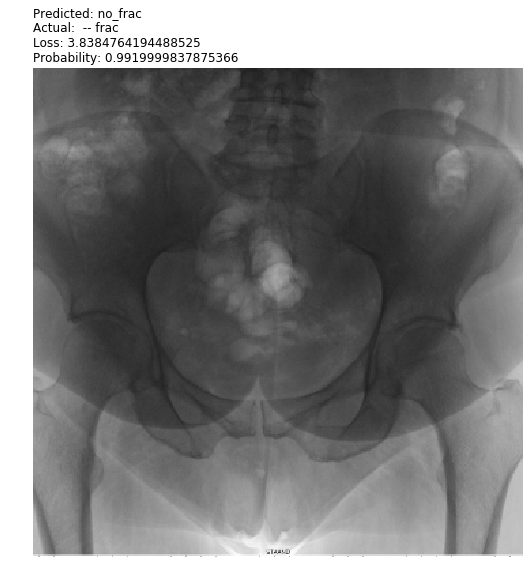

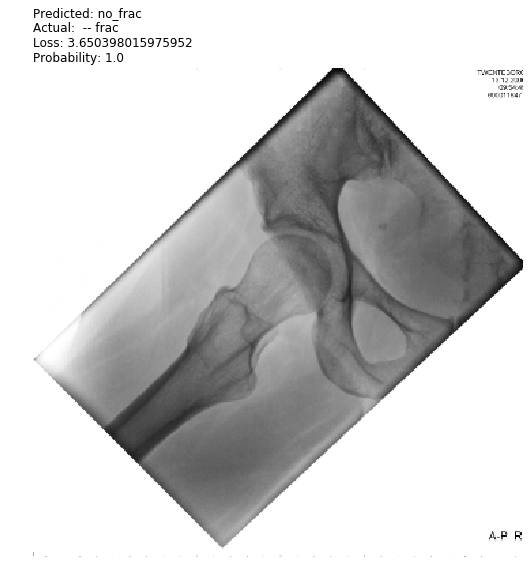

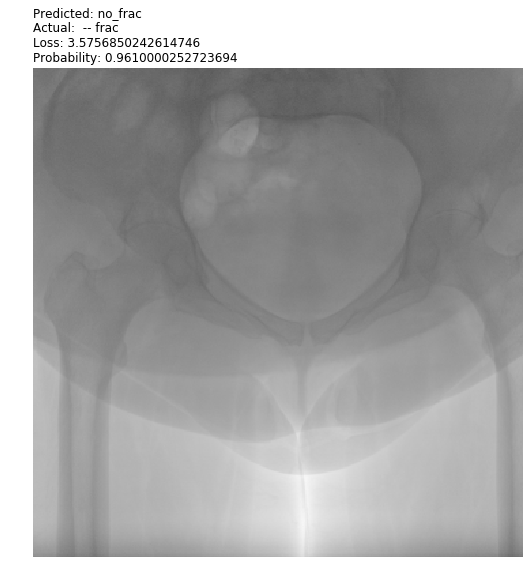

In [ ]:
interp.plot_multi_top_losses(10, figsize=(12,9), save_misclassified=False)

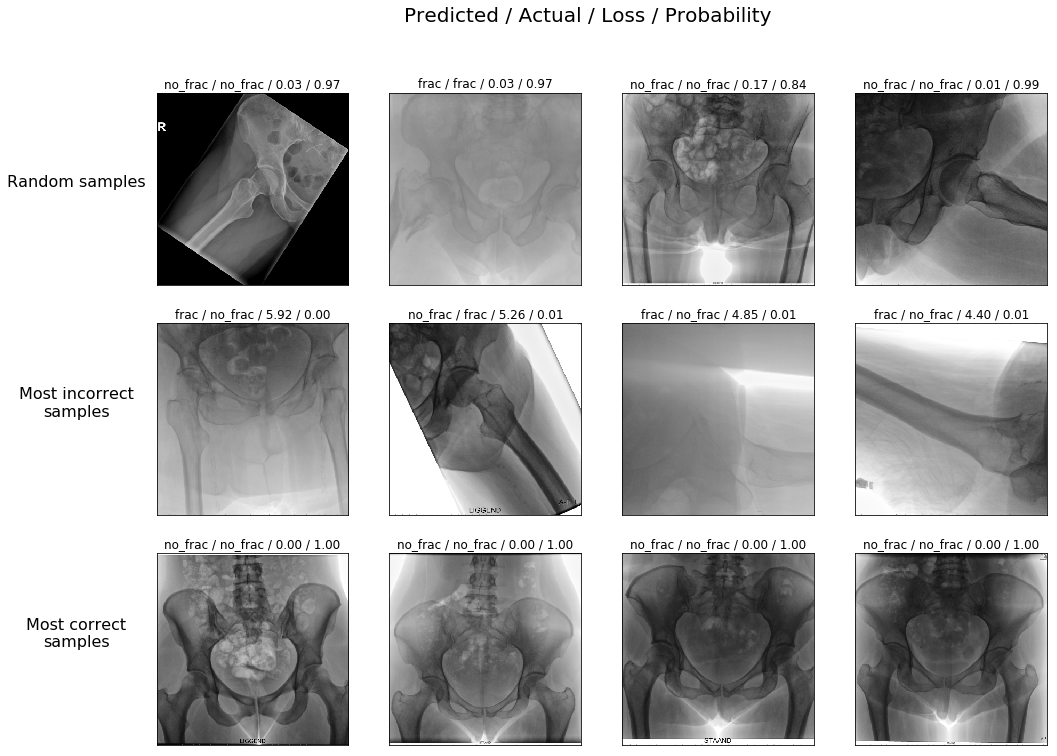

In [ ]:
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['frac','no_frac']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)
    
interp = ClassificationInterpretation.from_learner(learner)
    
plot_overview(interp, ['frac','no_frac'])


# Most correct:

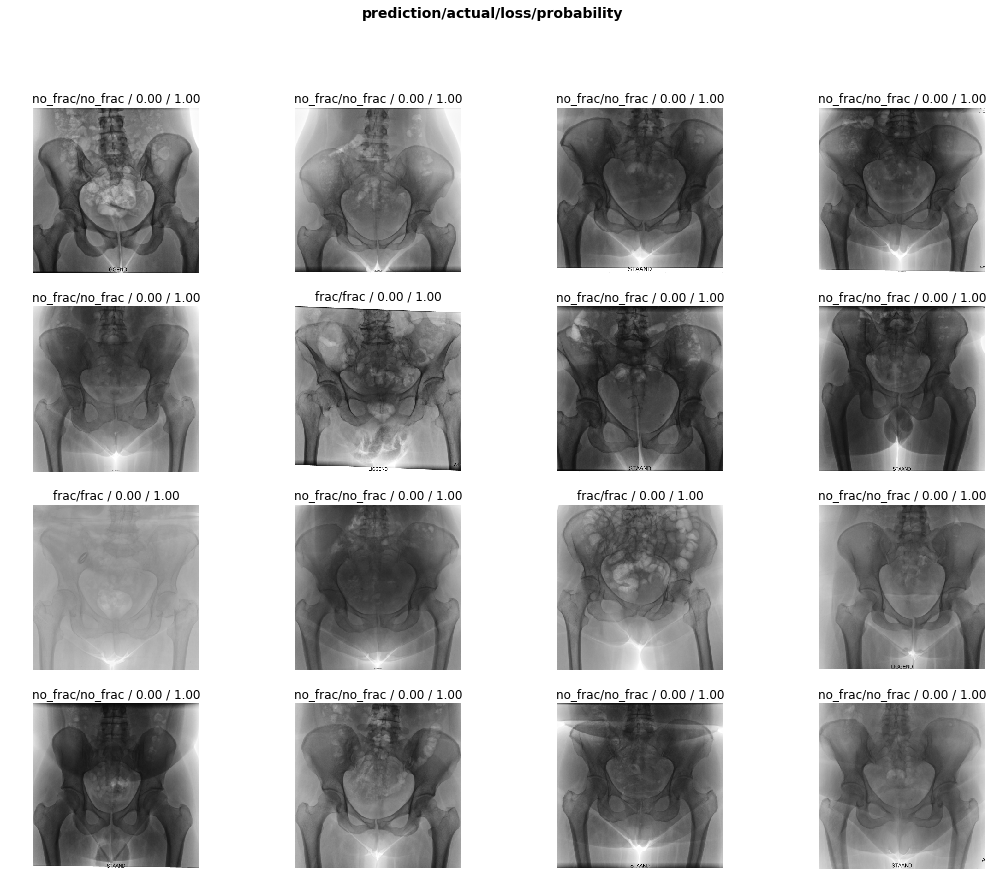

In [ ]:
interp.plot_top_losses(16,largest= False,heatmap=False, figsize=(18,14))


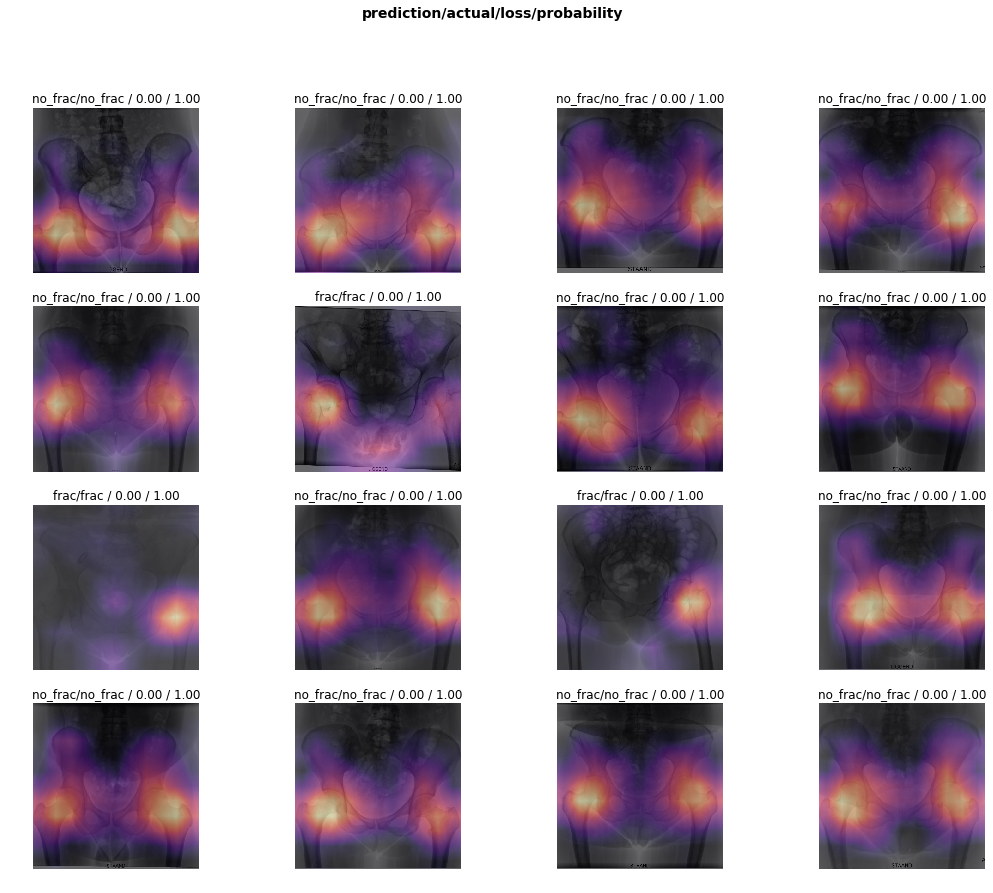

In [ ]:
interp.plot_top_losses(16,largest= False,heatmap=True, heatmap_thresh=25, figsize=(18,14))


# Most uncertain

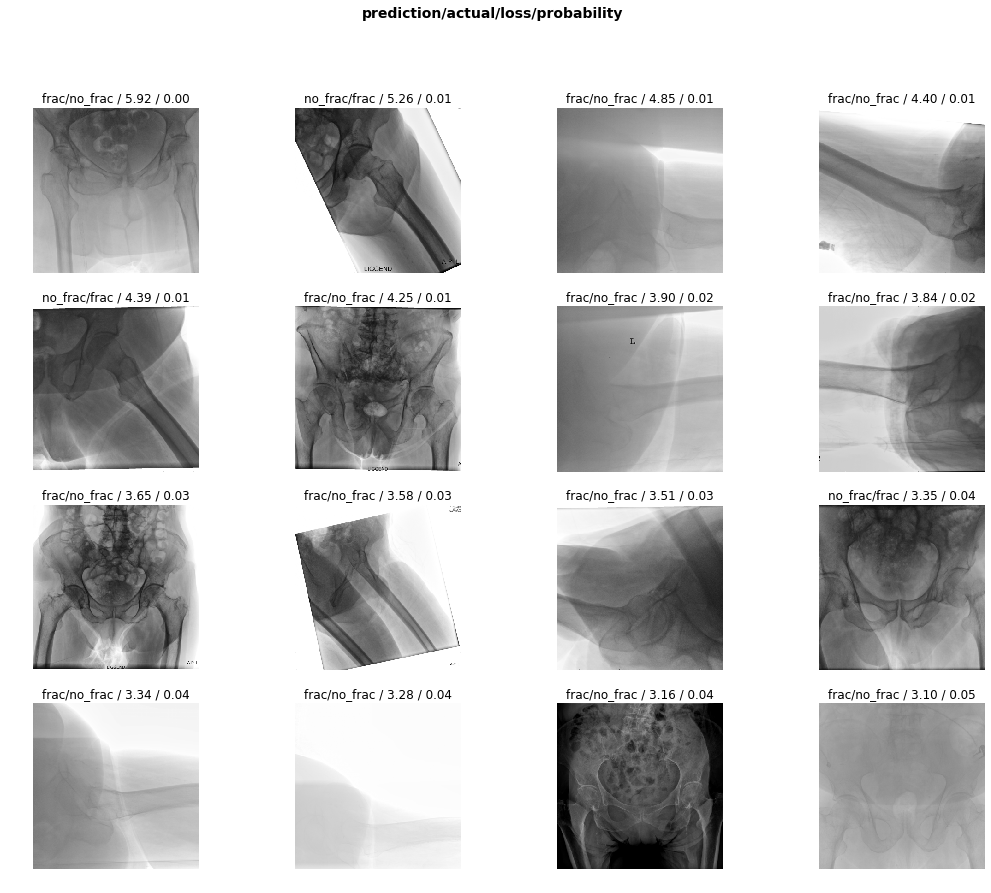

In [ ]:
interp.plot_top_losses(16,largest= True,heatmap=False, figsize=(18,14))


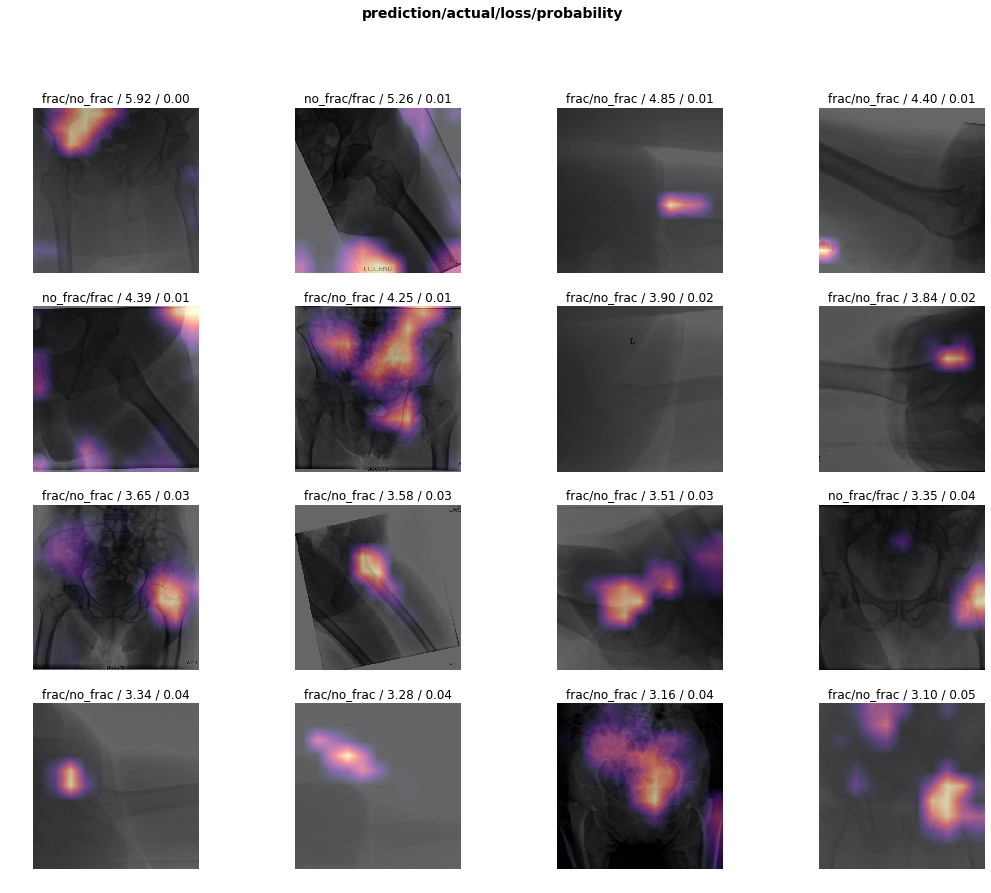

In [ ]:
interp.plot_top_losses(16,largest= True,heatmap=True, figsize=(18,14))


## Sample picture from validation folder (Fracture)

In [ ]:
fn = path/'valid/frac/043252600977441301657588018543750.png' #Replace with your own image
x = open_image(fn); x.show



<bound method Image.show of Image (3, 2240, 2656)>

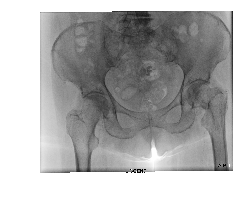

In [ ]:
x.show(figsize=(5,3))

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

hook_a,hook_g = hooked_backward()

acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

show_heatmap(mult)

data.classes[0]



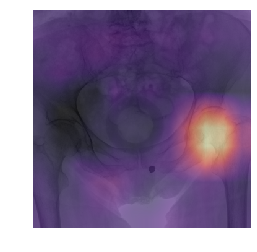

In [ ]:
hook_a,hook_g = hooked_backward(0)
acts = hook_a.stored[0].cuda()
grad = hook_g.stored[0][0].cuda()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)



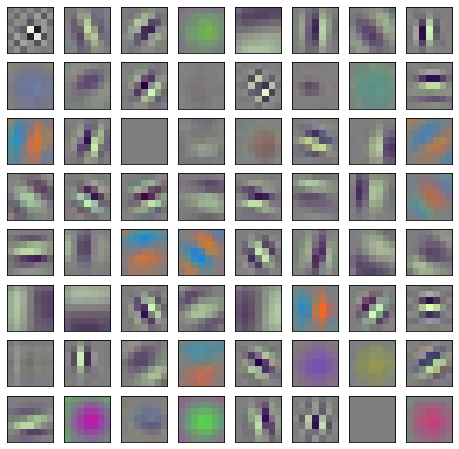

In [ ]:
from sklearn.preprocessing import minmax_scale

def visualize_first_layer(learn, save_name=None):
    conv1 = list(learn.model.children())[0][0]
    if isinstance(conv1, torch.nn.modules.container.Sequential):
        conv1 = conv1[0] # for some models, 1 layer inside
    weights = conv1.weight.data.cpu().numpy()
    weights_shape = weights.shape
    weights = minmax_scale(weights.ravel()).reshape(weights_shape)
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.rollaxis(weights[i], 0, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save_name:
        fig.savefig(str(save_name))

visualize_first_layer(learner)

In [ ]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9331742525100708 %.


### Misclassification

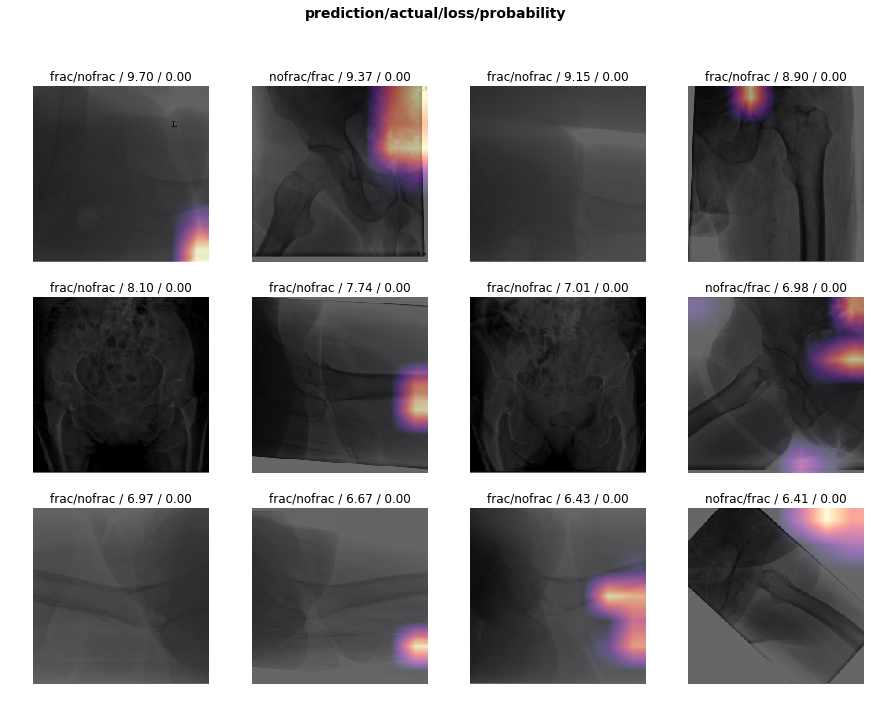

In [ ]:
interp.plot_top_losses(12,heatmap=True, figsize=(15,11))
